# Summary

Customer Churn Prediction can help companies identify customers who are likely to stop using their services and give those companies an opportunity to engage with them, interact with them and if possible, give them offers and incentives associated with new products.

In this project, I have analyzed and visualized the Telecom Churn Dataset and also used different models to predict if a customer is going to churn out.
The dataset consists of some features which do not have any relation with the churning rate. By cleaning and rescaling the dataset, the Logistic Regression model has achieved an accuracy of 81%

# Importing Kaggle Dataset into Google Colab 

In [2]:
from google.colab import files
files.upload() #choose files to upload in dropbox

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kartiknair","key":"efce4c669ce529b6cc65741d7d08d9ed"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d blastchar/telco-customer-churn

  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 23.6MB/s]


In [0]:
#Extracting the zip file to download the csv files
from zipfile import ZipFile
file_name="telco-customer-churn.zip"
with ZipFile(file_name,'r') as zip:
  print('Extracting file...')
  zip.extractall()
  print('Done')

# Importing necessarry libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [45]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [38]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [0]:
#df.info()
df.isna().any()
#df.isnull().any()

In [40]:
print("Churned",len(df[df.Churn == 'Yes']))
print("Not Churned",len(df[df.Churn == 'No']))

Churned 1869
Not Churned 5174


No     5174
Yes    1869
Name: Churn, dtype: int64


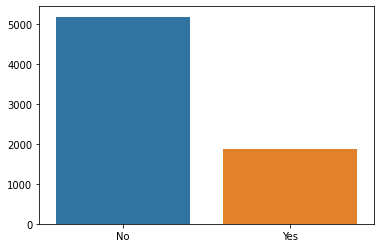

In [41]:
churn_count = df["Churn"].value_counts()
print(churn_count)
sns.barplot(churn_count.index, churn_count.values)

**The dataset is a bit skewed as the number of examples of Churned Customers makes up only around 25% of the total customers.**

**Let's check if the values in the attributes and edit the values in columns which don't make sense. **

In [0]:
dtenure = df[df['tenure'] == 0]
dtenure

**In the tenure column, customer's whose tenure is zero have their Total Charges as zero but their monthly charges is greater than zero.**

**So we'll have to copy values from Monthly Charges into the Total Charges column for those customers whose Tenure period is zero.**

In [0]:
df.loc[df['tenure'] == 0, 'TotalCharges'] = df['MonthlyCharges']
df[df['tenure'] == 0]

**Let's see how many unique values are there in each column**

In [48]:
print(df.nunique())

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6541
Churn                  2
dtype: int64


**Some of these columns like Multiple Lines, Internet Services, Online Security, Online Backup, Device Protection, etc. have three options whereas they should be having only two options (Yes or No). Let us find out what the third option is.**

In [54]:
df.MultipleLines.unique()

array(['No phone service', 'No', 'Yes'], dtype=object)

**We'll replace "No Phone Service" with "No" as they mean the same thing**

In [0]:
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service' : 'No'})

In [0]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0:'No',1:'Yes'})

In [55]:
df.InternetService.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

**This column looks fine**

In [97]:
column_values = df[["OnlineSecurity", "OnlineBackup", "DeviceProtection",
                    "TechSupport","StreamingTV","StreamingMovies"]].values
unique_values = np. unique(column_values)
print(unique_values)

['No' 'No internet service' 'Yes']


**For all these columns we'll replace "No Internet Service" with "No" as it means the same thing.**

In [0]:
replace_columns = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_columns : 
    df[i]  = df[i].replace({'No internet service' : 'No'})


# Relation of Churning with Categorical features

**I'll plot some graphs for the categorical features to see how the churning rate is affected by each feature.**

In [59]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

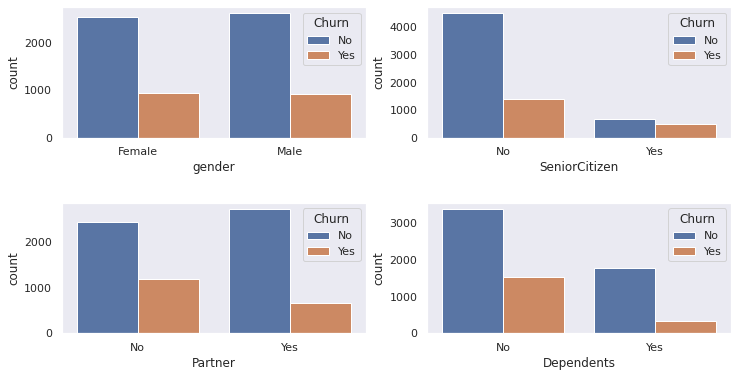

In [108]:
sns.set(style="dark")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,6))
sns.countplot(x="gender", hue="Churn", data=df, ax=ax1)
sns.countplot(x="SeniorCitizen", hue="Churn", data=df, ax=ax2)
sns.countplot(x="Partner", hue="Churn", data=df, ax=ax3, order=['No','Yes'])
sns.countplot(x="Dependents", hue="Churn", data=df, ax=ax4)
plt.subplots_adjust(hspace = 0.5)
plt.show()

*   **The churning rate seems to be unaffected by the gender of the customers.** 

*   **Senior Citizens tend to churn less whereas customers with no partner or dependents tend to churn more.**

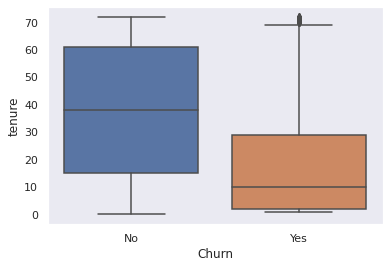

In [71]:
sns.boxplot(x="Churn", y="tenure", data=df)

* **Around 75% of customers that churned out had a tenure of less than 30 months.**
* **The loyal customers who did not churn out had around 50% of them with tenure greater than 40 months**

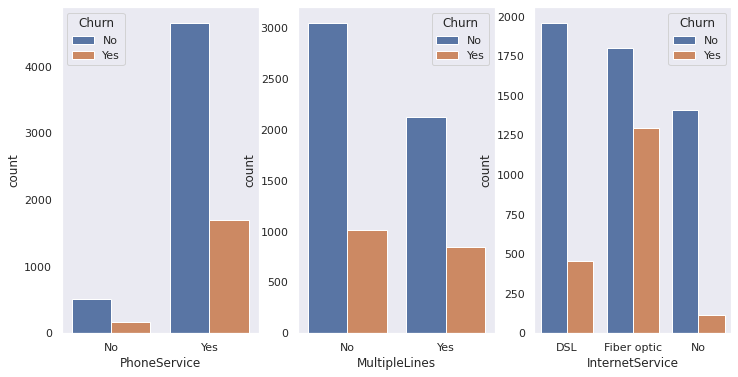

In [101]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
sns.countplot(x="PhoneService", hue="Churn", data=df, ax=ax[0])
sns.countplot(x="MultipleLines", hue="Churn", data=df, ax=ax[1])
sns.countplot(x="InternetService", hue="Churn", data=df, ax=ax[2])
#plt.subplots_adjust(hspace = 0.5)
plt.show()

* **Customers with Inernet Service, especially those with Fibre Optic Cable have a higher probabilty of churning out than customers with no Internet Service.**
* **Having "Multiple Lines" does not have any effect on the churning rate.** 
* **The ratio of Churn to No Churn seems to be higher for customers with Phone Service.**

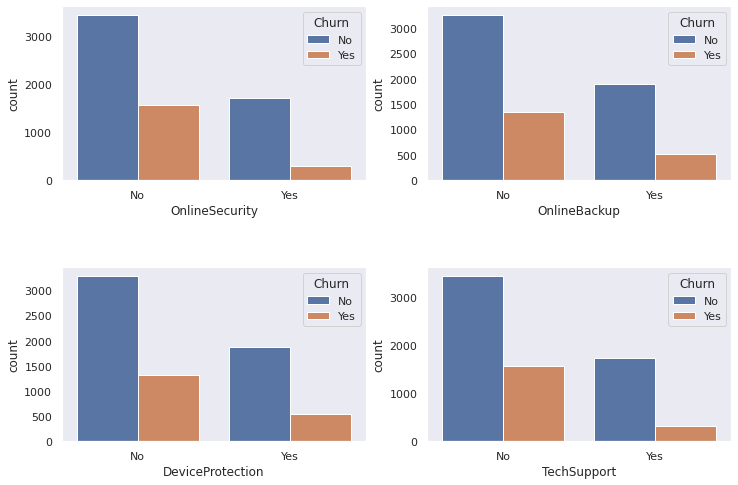

In [103]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8))
sns.countplot(x="OnlineSecurity", hue="Churn", data=df, ax=ax1)
sns.countplot(x="OnlineBackup", hue="Churn", data=df, order=['No','Yes'], ax=ax2)
sns.countplot(x="DeviceProtection", hue="Churn", data=df, ax=ax3)
sns.countplot(x="TechSupport", hue="Churn", data=df, ax=ax4)
plt.subplots_adjust(hspace = 0.5)
plt.show()

* **Customers with no Online Security and Tech Support tend to churn out more.**
* **The ratio of Churn to No Churn for Online Backup and Device Protection seem to be proportionate.**

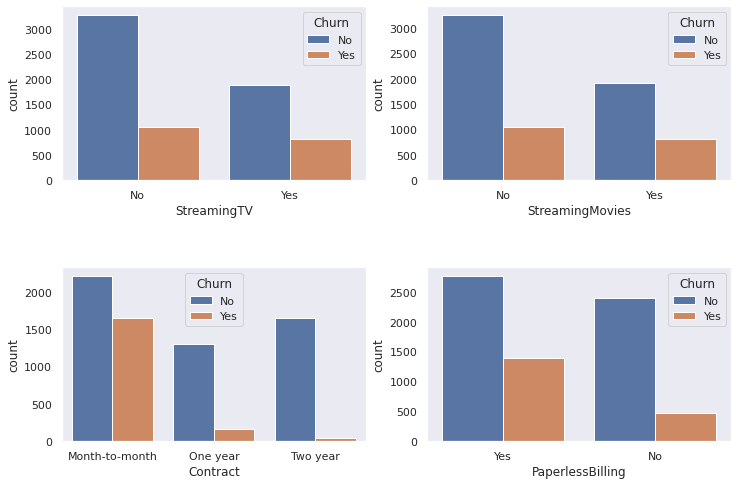

In [109]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8))
sns.countplot(x="StreamingTV", hue="Churn", data=df, ax=ax1)
sns.countplot(x="StreamingMovies", hue="Churn", data=df, ax=ax2)
sns.countplot(x="Contract", hue="Churn", data=df, ax=ax3)
sns.countplot(x="PaperlessBilling", hue="Churn", data=df, ax=ax4)
plt.subplots_adjust(hspace = 0.5)
plt.show()

* **The ratio of churn to no churn is higher in customers with "StreamingTV" and "StreamingMovies" than those without them.**
* **Month-to-month contract customers have a high churning rate.**
* **Paperless Billing method tends to increase the possibility of churning.** 

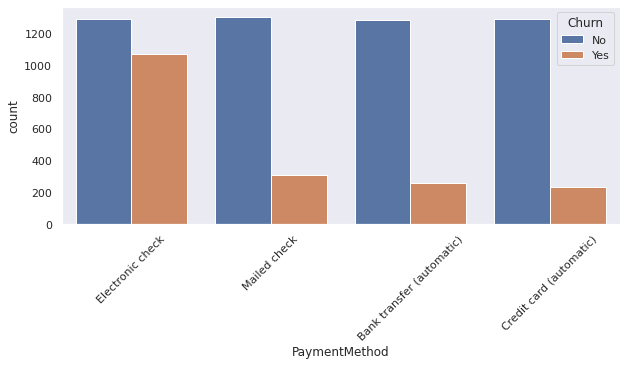

In [92]:
fig, ax =plt.subplots(figsize=(10,4))
pay_catg=df['PaymentMethod'].unique()
ax.set_xticklabels(pay_catg, rotation=45)
sns.countplot(x="PaymentMethod", hue="Churn", data=df, ax=ax)
plt.show()

* **Customers with Electronic Check paymnent method have a higher tendency to churn out. This feature is similar to the "Paperless Billing" feature above.**

# Relation of Churning with Numerical Features

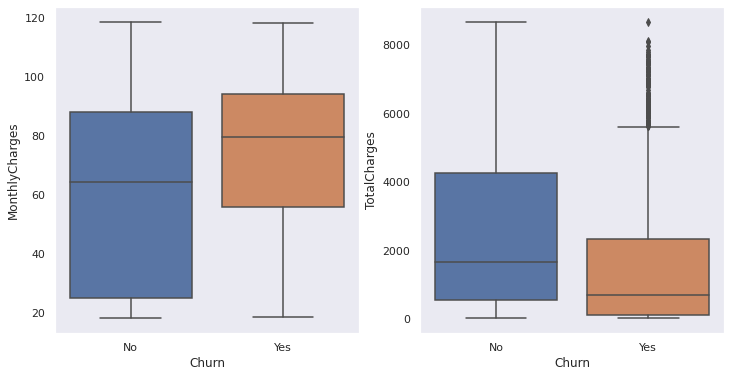

In [96]:
#Converted the Total Charges entries into numeric as some values are non-numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df[df['TotalCharges'].notnull()]
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, ax=ax[0])
sns.boxplot(x="Churn", y="TotalCharges", data=df, ax=ax[1])
plt.show()

**We will also check the correlation between those numeric featues**

In [111]:
numeric_df = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
numeric_df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.826164
MonthlyCharges,0.247900,1.000000,0.651182
TotalCharges,0.826164,0.651182,1.000000


* **We observe that there is 82.6% correlation between Tenure and Total Charges which is pretty high.**
* **There is little correlation between Tenure and Monthly Charges.**

In [0]:
sns.pairplot(df, x_vars=["TotalCharges", "MonthlyCharges"], y_vars='tenure', height=7, aspect=1, kind="reg")

# Data Preprocessing

**From this dataset, we can remove columns which have less or no effect on the predictions**

In [118]:
df.nunique()

SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          2
InternetService        3
OnlineSecurity         2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6534
Churn                  2
dtype: int64

We will modify the dataset as follows

In [0]:
# X= df.drop(['customerID','gender','OnlineBackup','DeviceProtection'],axis=1)
# y = pd.Series([0]*len(X))
#df.drop(['customerID','gender','OnlineBackup','DeviceProtection'],axis=1, inplace=True)

# Creating dummy columns for categorical variables
dft = pd.get_dummies(df, columns=['InternetService','Contract','PaymentMethod'])

# Creating binary columns for boolean values 
dft.Partner.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.Dependents.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.SeniorCitizen.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.PhoneService.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.MultipleLines.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.OnlineSecurity.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.TechSupport.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.StreamingTV.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.StreamingMovies.replace(['Yes', 'No'], [1, 0], inplace=True)
dft.PaperlessBilling.replace(['Yes', 'No'], [1, 0], inplace=True)

#Create binary column for target variable
dft.Churn.replace(['Yes', 'No'], [1, 0], inplace=True)

pd.set_option('max_columns', 100)

In [203]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   Partner                                  7043 non-null   int64  
 2   Dependents                               7043 non-null   int64  
 3   tenure                                   7043 non-null   int64  
 4   PhoneService                             7043 non-null   int64  
 5   MultipleLines                            7043 non-null   int64  
 6   OnlineSecurity                           7043 non-null   int64  
 7   TechSupport                              7043 non-null   int64  
 8   StreamingTV                              7043 non-null   int64  
 9   StreamingMovies                          7043 non-null   int64  
 10  PaperlessBilling                         7043 no

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X= dft.drop(['Churn'],axis=1)
y= dft["Churn"]


**Scaling Numeric Columns into range (0,1)**

In [0]:
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [0]:
X_train

# Predicting Churn using Classification Models

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score

def predict_churn(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    acc_score = accuracy_score(y_test, y_pred) 
    print("Accuracy Score: ", acc_score)
    print(classification_report(y_test, y_pred))
    fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])
    plt.plot(fpr,tpr,label = "AUC = " + str(np.around(roc_auc_score(y_test,y_pred),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    plt.title('ROC Curve')

## Using Logistic Regression

Accuracy Score:  0.812588736393753
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1562
           1       0.67      0.56      0.61       551

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.81      2113



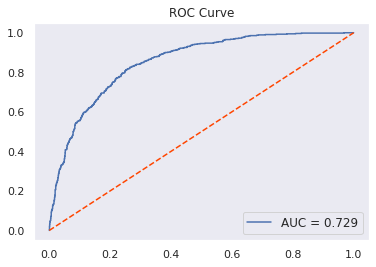

In [215]:
model = LogisticRegression(solver='liblinear')
predict_churn(model, X_train, X_test, y_train, y_test)

## Using Decision Tree Classifier

Accuracy Score:  0.7321344060577378
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1562
           1       0.49      0.50      0.49       551

    accuracy                           0.73      2113
   macro avg       0.65      0.66      0.66      2113
weighted avg       0.73      0.73      0.73      2113



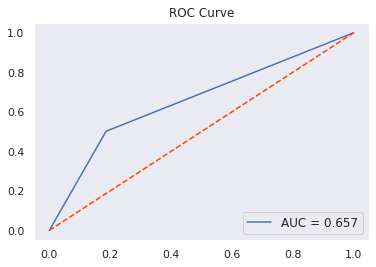

In [216]:
model = DecisionTreeClassifier()
run_classification(model, X_train, X_test, y_train, y_test)


Using K-Nearest Neighbours

Accuracy Score:  0.795551348793185
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1562
           1       0.65      0.47      0.55       551

    accuracy                           0.80      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.80      0.78      2113



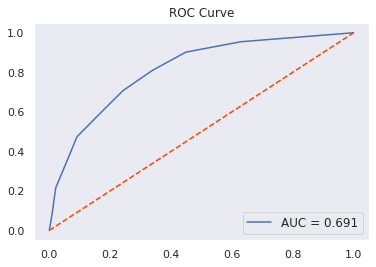

In [217]:
model = KNeighborsClassifier(n_neighbors=10)
run_classification(model, X_train, X_test, y_train, y_test)

## Using Support Vector Machine

Accuracy Score:  0.7486985328916232
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1562
           1       0.51      0.80      0.62       551

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.81      0.75      0.76      2113



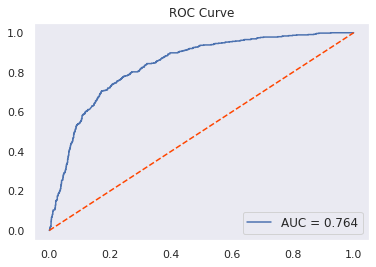

In [218]:
model = SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
run_classification(model, X_train, X_test, y_train, y_test)

# Conclusion

Accuracy Scores:


1.   Logistic Regression: **81%**
2.   Decision Tree Classifier: **73%**
3.   K-Nearest Neighbiours: **80%**
4.   Support Vector Machine:**75%**



* **Thus, using Logistic Regression Model we could predict if a customer would churn or not with an accuracy of 81%, which is quite satisfactory.**
* **The accuracy has been improved by removing certain features which have less or no effect on the churning rate.**
* **There is 82.6% correlation between Tenure and Total Charges and very little correlation between Tenure and Monthly Charges.**
* **Customers are more likely to churn if they have no partners, no dependents,and no special services like Tech Support, Online Backup, Online Security, Device Protection**
* **Customers with month-to-month contract are less likely to churn**